In [1]:
import numpy as np
import pennylane as qml
from pennylane import qchem as qchem
from pennylane import numpy as np

In [2]:
#load the molecule with nuclear coordinates
symbols = ['H', 'H']
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

In [3]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print('Number of qubits:', qubits)
print('Hamiltonian:', H)

/opt/anaconda3/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


Number of qubits: 4
Hamiltonian:   (-0.24274501727498227) [Z2]
+ (-0.24274501727498227) [Z3]
+ (-0.042072543031530185) [I0]
+ (0.17771358191549919) [Z0]
+ (0.1777135819154993) [Z1]
+ (0.12293330460167415) [Z0 Z2]
+ (0.12293330460167415) [Z1 Z3]
+ (0.16768338881432718) [Z0 Z3]
+ (0.16768338881432718) [Z1 Z2]
+ (0.1705975924056083) [Z0 Z1]
+ (0.17627661476093914) [Z2 Z3]
+ (-0.04475008421265302) [Y0 Y1 X2 X3]
+ (-0.04475008421265302) [X0 X1 Y2 Y3]
+ (0.04475008421265302) [Y0 X1 X2 Y3]
+ (0.04475008421265302) [X0 Y1 Y2 X3]


In [4]:
dev = qml.device("default.qubit", wires=qubits)

In [5]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [6]:
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

In [7]:
@qml.qnode(dev)
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

In [8]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [9]:
theta = np.array(0.0, requires_grad=True)

In [10]:
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


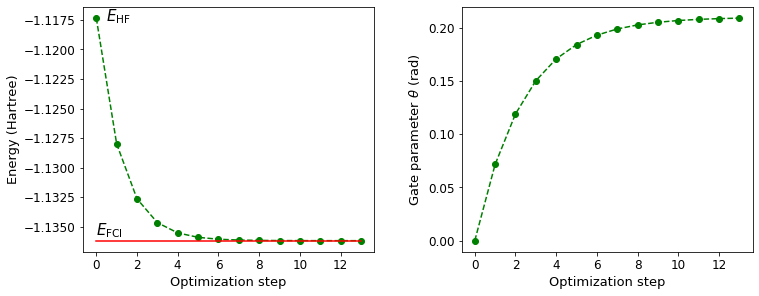

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()